In [2]:
from torch import nn
from collections import OrderedDict
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import torch
import torch.nn.functional as F
from IPython.display import display


In [3]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


In [4]:
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function" #which actually corresponds to [1x1] conv
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))    
        return bottleneck_output

    def forward(self, input):  
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


In [5]:
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


In [6]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part 
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-169 config: [6,12,32,32]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


In [7]:
def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model

def densenet169(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet121', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


# Initializing densenet169 && Model Summary

In [8]:
my_model=densenet169()
#print(summary(my_model,torch.zeros((1,3,256,256))))
print(my_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Importing weights of Pretrained Model

In [15]:
true_model=models.densenet169(pretrained=True)

In [16]:
PATH = './densenet169_pretrained.pth'
torch.save(true_model.state_dict(), PATH)

In [17]:
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Testing Densenet-169

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


/home/dhiab/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


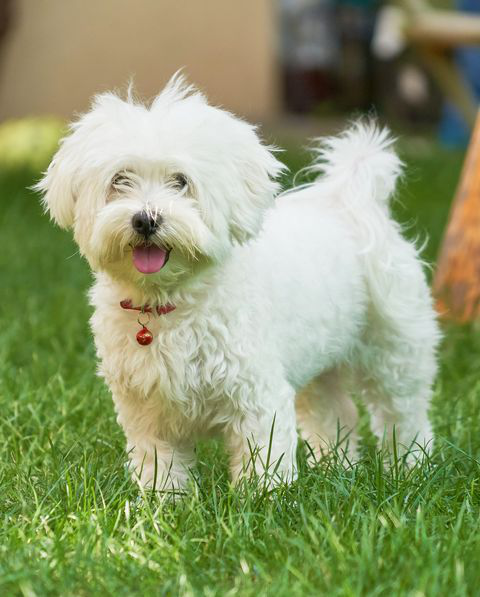

Maltese dog    0.906   
Tibetan terrier    0.033   
Japanese spaniel    0.016   
Lhasa    0.013   
Shih-Tzu    0.004   


In [12]:
filename="./samples/dog.jpg"
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.shape)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    my_model.to('cuda')

with torch.no_grad():
    my_model.eval()
    output = my_model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = F.softmax(output[0], dim=0)
# Read the categories
with open("./samples/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
display(input_image)
print('='*20)
for i in range(top5_prob.size(0)):
    
    print(f'{categories[top5_catid[i]]}    {top5_prob[i].item():.3f}   ')
print('='*20)

In [13]:
# activation={}
# def get_activation(name):
#         #get activation of the layer called name
#         def hook(model, input, output):
                
#                 """Run activation hook.
                
#                 Parameters :
#                 ----------
#                 inst    :   torch.nn.Module
#                         The layer we want to attach the hook to.
#                 input   :   torch.Tensor
#                         The input to the `forward` method.
#                 out     :   torch.Tensor
#                         The output of the `forward` method.
                
#                 """
                
#                 activation[name] = output.detach()
#         return(hook)
# my_model.features.denseblock1.register_forward_hook(get_activation('denseblock1'))
# my_model.features.denseblock2.register_forward_hook(get_activation('denseblock2'))
# my_model.features.denseblock1.denselayer2.register_forward_hook(get_activation('denselayer2'))


# y=my_model(torch.zeros((1,3,512,384)).to('cuda'))
# print(y.shape)
# print(activation['denseblock1'].shape)
# print(activation['denseblock2'].shape)
# print(activation['denselayer2'].shape)
y=torch.zeros((1,3,512,384))
nn.AvgPool2d(kernel_size=y.shape[-2:])(y).squeeze().shape


torch.Size([3])